In [6]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import scipy.stats as sp
import statsmodels.stats.diagnostic as ssd

In [7]:
df1=pd.DataFrame(pd.read_csv ('C:/Users/borsh/OneDrive/Рабочий стол/BI/projects/ForestlyActivitiesProject/project data/data-1760379126636.csv'))
df2=pd.DataFrame(pd.read_csv ('C:/Users/borsh/OneDrive/Рабочий стол/BI/projects/ForestlyActivitiesProject/scripts/data-1759582857171.csv'))
df2
df2_=df2.drop([0,1,2])
df2_
df = df1.merge(df2_, on='year', how='outer')
df = df.sort_values('year')
df_=df.drop(0)# 2018 has extremely low value, that get a bad correlation
df_

,wood_fuel_cost,year,industrial_rw_cost,sum
1,488.376000,2019,1404.528000,17886600.0
2,450.210271,2020,1316.084700,16773000.0
3,568.388960,2021,2290.164254,16666900.0
4,814.320000,2022,2823.324000,15085100.0
5,911.826630,2023,2649.323396,15252100.0
6,906.448000,2024,2887.800112,14885800.0


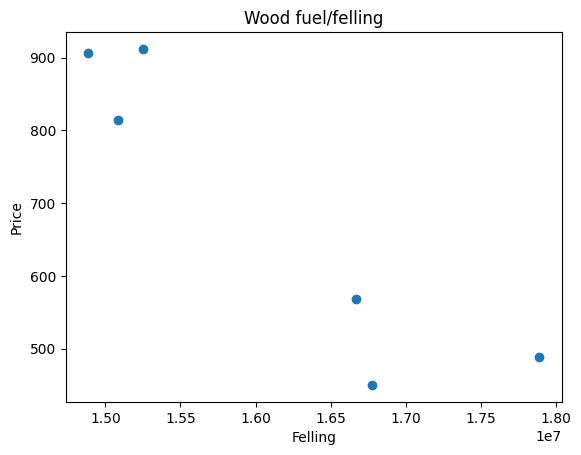

In [8]:
#show the plot to look at the data 
plt.scatter(x=df_['sum'],y=df_['wood_fuel_cost'])
plt.title('Wood fuel/felling')
plt.xlabel('Felling')
plt.ylabel('Price')
plt.show()


In [9]:
df_.corr()

,wood_fuel_cost,year,industrial_rw_cost,sum
wood_fuel_cost,1.000000,0.938781,0.921223,-0.919181
year,0.938781,1.000000,0.906763,-0.942746
industrial_rw_cost,0.921223,0.906763,1.000000,-0.902704
sum,-0.919181,-0.942746,-0.902704,1.000000


## Biuld the OLS 

In [10]:
x = sm.add_constant(df_['sum'])
y = df_['wood_fuel_cost']
OLS_basic = sm.OLS(y,x).fit()
print(OLS_basic.summary())

                            OLS Regression Results                            
Dep. Variable:         wood_fuel_cost   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     21.79
Date:                Thu, 30 Oct 2025   Prob (F-statistic):            0.00953
Time:                        17:09:44   Log-Likelihood:                -34.512
No. Observations:                   6   AIC:                             73.02
Df Residuals:                       4   BIC:                             72.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3303.4528    561.192      5.886      0.0

C:\Users\borsh\PycharmProjects\PythonProject\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


## Build regresstion with lags

In [11]:
df_['sum_l']=df_['sum'].shift(1)
df_lag=df_.dropna()

x_lag = sm.add_constant(df_lag['sum_l'])
y_lag= df_lag['wood_fuel_cost']

OLS_lag= sm.OLS(y_lag,x_lag).fit()
print(OLS_lag.summary())

                            OLS Regression Results                            
Dep. Variable:         wood_fuel_cost   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     15.50
Date:                Thu, 30 Oct 2025   Prob (F-statistic):             0.0292
Time:                        17:09:45   Log-Likelihood:                -28.714
No. Observations:                   5   AIC:                             61.43
Df Residuals:                       3   BIC:                             60.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3415.9609    683.529      4.998      0.0

C:\Users\borsh\PycharmProjects\PythonProject\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


That means that price less depence by past values of felling

## Checking the lags

In [12]:
res=OLS_lag.resid
stat,p=sp.shapiro(res)
print('Shapiro p-value: ', p)

Shapiro p-value:  0.2655268707447847


p>0.05 that means than we have normal residuals

### Autocorrelation

In [13]:
ac_test =ssd.acorr_ljungbox(res,lags=[1,2,3],return_df=True)
print(ac_test)

    lb_stat  lb_pvalue
1  1.960546   0.161455
2  1.993178   0.369136
3  2.004078   0.571561


all p-values > 0.05, that means that autocorrelation is epcente

## check the errors stability

In [14]:
bp_test = ssd.het_breuschpagan(res,OLS_lag.model.exog)
print(bp_test)

(np.float64(0.3475871108593781), np.float64(0.5554821963600549), np.float64(0.22413344589687717), np.float64(0.6682268169782112))


all values more that 0.05 errors are stable

## Confidence interval (basic model)

In [15]:
pred = OLS_basic.get_prediction(x)
pred_summary = pred.summary_frame(alpha = 0.5)
print(pred_summary[['mean','mean_ci_lower','mean_ci_upper']])

         mean  mean_ci_lower  mean_ci_upper
1  398.389567     344.205098     452.574036
2  579.255600     546.025448     612.485752
3  596.487898     564.618188     628.357607
4  853.396924     815.073580     891.720268
5  826.273515     790.721861     861.825170
6  885.766357     843.795777     927.736936


## Prediction interval(basic model)

In [16]:
pred = OLS_basic.get_prediction(x)
pred_summary = pred.summary_frame(alpha = 0.5)
print(pred_summary[['mean','obs_ci_lower','obs_ci_upper']])

         mean  obs_ci_lower  obs_ci_upper
1  398.389567    310.577495    486.201639
2  579.255600    502.579357    655.931843
3  596.487898    520.391369    672.584426
4  853.396924    774.379951    932.413896
5  826.273515    748.563005    903.984025
6  885.766357    804.917530    966.615183


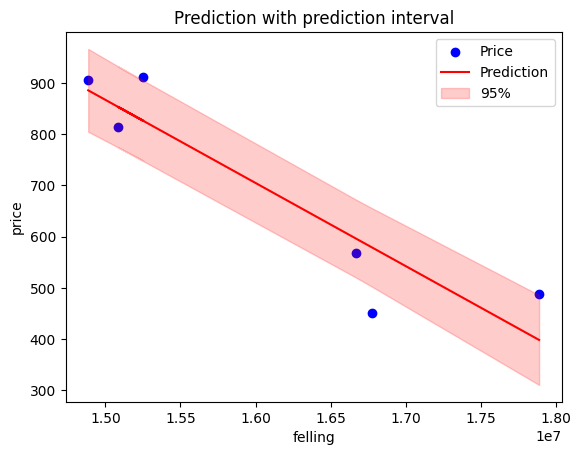

In [17]:
plt.scatter(df_['sum'],df_['wood_fuel_cost'],color ='blue',label = 'Price')
plt.plot(df_['sum'],pred_summary['mean'],color ='red', label = 'Prediction')
plt.fill_between(df_['sum'], pred_summary['obs_ci_lower'], pred_summary['obs_ci_upper'],color = 'red', alpha =0.2, label = '95%')
plt.xlabel('felling')
plt.ylabel('price')
plt.title('Prediction with prediction interval')
plt.legend()
plt.show()

## Confidence interval (lags model)

In [18]:
pred = OLS_basic.get_prediction(x_lag)
pred_summary = pred.summary_frame(alpha = 0.5)
print(pred_summary[['mean','mean_ci_lower','mean_ci_upper']])

         mean  mean_ci_lower  mean_ci_upper
2  398.389567     344.205098     452.574036
3  579.255600     546.025448     612.485752
4  596.487898     564.618188     628.357607
5  853.396924     815.073580     891.720268
6  826.273515     790.721861     861.825170


In [19]:
pred = OLS_basic.get_prediction(x_lag)
pred_summary_lag = pred.summary_frame(alpha = 0.5)
print(pred_summary_lag[['mean','obs_ci_lower','obs_ci_upper']])

         mean  obs_ci_lower  obs_ci_upper
2  398.389567    310.577495    486.201639
3  579.255600    502.579357    655.931843
4  596.487898    520.391369    672.584426
5  853.396924    774.379951    932.413896
6  826.273515    748.563005    903.984025


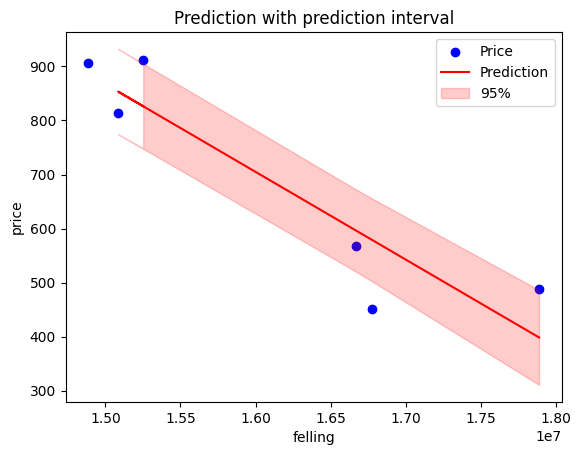

In [20]:
plt.scatter(df_['sum'],df_['wood_fuel_cost'],color ='blue',label = 'Price')
plt.plot(x_lag['sum_l'],pred_summary_lag['mean'],color ='red', label = 'Prediction')
plt.fill_between(x_lag['sum_l'], pred_summary_lag['obs_ci_lower'], pred_summary_lag['obs_ci_upper'],color = 'red', alpha =0.2, label = '95%')
plt.xlabel('felling')
plt.ylabel('price')
plt.title('Prediction with prediction interval')
plt.legend()
plt.show()

## Lets make a prediction by basic and lag models

### Basic model

In [25]:
X=sm.add_constant(pd.Series(pd.concat([df_['sum'],pd.Series([1.409218e+07,1.359063e+07, 1.308907e+07])]), name='felling value'))
prediction= OLS_basic.get_prediction(X)
forecast=prediction.summary_frame(alpha=0.05)
forecast.index = X['felling value']
print(forecast[['mean','mean_ci_lower','mean_ci_upper','obs_ci_lower','obs_ci_upper']])

                      mean  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
felling value                                                            
17886600.0      398.389567     195.283320     601.495814     69.232881   
16773000.0      579.255600     454.694973     703.816227    291.840698   
16666900.0      596.487898     477.026783     715.949012    311.246011   
15085100.0      853.396924     709.744866     997.048982    557.207981   
15252100.0      826.273515     693.010919     959.536112    534.981744   
14885800.0      885.766357     728.442921    1043.089793    582.710851   
14092180.0     1014.662640     794.458686    1234.866594    674.689469   
13590630.0     1096.122194     832.389941    1359.854447    726.464680   
13089070.0     1177.583372     868.851426    1486.315318    774.585369   

               obs_ci_upper  
felling value                
17886600.0       727.546253  
16773000.0       866.670502  
16666900.0       881.729785  
15085100.0      1149.585867  
15252

### Lag model

In [26]:
X=sm.add_constant(pd.Series(pd.concat([df_['sum'],pd.Series([1.409218e+07,1.359063e+07, 1.308907e+07])]), name='felling value'))
prediction= OLS_lag.get_prediction(X)
forecast=prediction.summary_frame(alpha=0.05)
forecast.index = X['felling value']
print(forecast[['mean','mean_ci_lower','mean_ci_upper','obs_ci_lower','obs_ci_upper']])

                      mean  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
felling value                                                            
17886600.0      474.725234     225.944580     723.505889     77.139585   
16773000.0      657.843325     507.308362     808.378288    313.106744   
16666900.0      675.290190     529.656423     820.923957    332.665426   
15085100.0      935.398124     719.212550    1151.583697    557.352178   
15252100.0      907.936988     708.269554    1107.604422    539.087941   
14885800.0      968.170605     731.055417    1205.285793    577.778306   
14092180.0     1098.671843     770.153935    1427.189751    646.890313   
13590630.0     1181.145692     791.179664    1571.111720    682.892707   
13089070.0     1263.621185     810.728028    1716.514343    714.717964   

               obs_ci_upper  
felling value                
17886600.0       872.310884  
16773000.0      1002.579905  
16666900.0      1017.914954  
15085100.0      1313.444069  
15252